In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Material:
    def __init__(self, E, sigma_y):
        self.E = E
        self.sigma_y = sigma_y
        sigma_trial = self.E * eps
        if sigma_trial < self.sigma_y:
            sigma = sigma_trial
            dsigma_deps = self.E
        else:
            sigma = self.sigma_y * ((self.E*eps)/ self.sigma_y)**0.4
            dsigma_deps = 0.4*self.sigma_y**(1-0.4)*(self.E**0.4)*(eps**(0.4-1))
        return sigma, dsigma_deps

In [ ]:
class Element1D:
    def __init__(self, node_ids, length, area, material):
        self.node_ids = node_ids
        self.length = length
        self.area = area
        self.material = material
        self.eps = 0
        self.sigma = 0

    def compute_strain(self, U):
        u1 = U[self.node_ids[0]]
        u2 = U[self.node_ids[1]]
        self.eps = (u2 - u1) / self.length
        return self.eps

    def compute_stress_tangent(self):
        sigma, dsigma_deps = self.material.get_stress(self.eps)
        self.sigma = sigma
        return sigma, dsigma_deps

    def get_element_stiffness_and_residual(self, U):
        eps = self.compute_strain(U)
        sigma, dsigma_deps = self.compute_stress_tangent()
        factor = (dsigma_deps * self.area) / self.length
        ke = factor * np.array([[1, -1], [-1, 1]], dtype=float)
        f_int = sigma * self.area * np.array([-1.0, 1.0])
        return ke, f_int

In [ ]:
class Mesh:
    def __init__(self, coords, connectivity, areas, material):
        self.coords = coords
        self.connectivity = connectivity
        self.num_elems = connectivity.shape[0]
        self.elements = []

        for e in range(self.num_elems):
            node_ids = connectivity[e, :]
            x1 = coords[node_ids[0]]
            x2 = coords[node_ids[1]]
            length = abs(x2 - x1)
            area = areas[e]  
            elem = Element1D(node_ids=node_ids, length=length, area=area, material=material)
            self.elements.append(elem)

In [ ]:
class FEMSolver:
    def __init__(self, mesh, bc, external_force, n_increments=20, max_iter=20, tol=1e-6):
        self.mesh = mesh
        self.bc = bc
        self.external_force = external_force
        self.n_increments = n_increments
        self.max_iter = max_iter
        self.tol = tol
        self.num_nodes = len(mesh.coords)
        self.U = np.zeros(self.num_nodes, dtype=float)  
        self.fixed_values = []
        self.fixed_dofs = []

        for node_id, val in bc.items():
            self.fixed_dofs.append(node_id)
            self.fixed_values.append(val)
        self.fixed_values = np.array(self.fixed_values, dtype=float)
        self.fixed_dofs = np.array(self.fixed_dofs, dtype=int)

        self.displacement_history = []
        self.force_history = []

    def apply_boundry_conditions(self, K, R):
        for i, dof in enumerate(self.fixed_dofs):
            K[dof, :] = 0.0
            K[:, dof] = 0.0
            K[dof, dof] = 1.0
            R[dof] = self.fixed_values[i] - self.U[dof]

    def assemble_system(self):
        K = np.zeros((self.num_nodes, self.num_nodes), dtype=float)
        R_int = np.zeros(self.num_nodes, dtype=float)

        for elem in self.mesh.elements:
            ke, f_int = elem.get_element_stiffness_and_residual(self.U)
            ids = elem.node_ids

            for i_local, i_global in enumerate(ids):
                for j_local, j_global in enumerate(ids):
                    K[i_global, j_global] += ke[i_local, j_local]

            R_int[ids[0]] += f_int[0]
            R_int[ids[1]] += f_int[1]

        return K, R_int

    def solve(self):

        F_total = self.external_force.copy()
        F_step = F_total / self.n_increments

        for inc in range(self.n_increments):
            F_current = F_step * (inc + 1)

            for iteration in range(self.max_iter):
                K, R_int = self.assemble_system()
                R = F_current - R_int  

                self.apply_boundry_conditions(K, R)

                dU = np.linalg.solve(K, R)

                self.U += dU

                if (np.linalg.norm(R) < self.tol) and (np.linalg.norm(dU) < self.tol):
                    print(f"  -> Converged at iteration {iteration+1} in increment {inc+1}")
                    break
            self.displacement_history.append(self.U[-1]) 
            self.force_history.append(F_current[-1])

        print("Finished Nonlinear Analysis.")

        max_disp = np.max(np.abs(self.U))
        max_stress = max([elem.sigma for elem in self.mesh.elements])
        max_strain = max([elem.eps for elem in self.mesh.elements])

        print(f"Maximum Displacement = {max_disp:.6e} m")
        print(f"Maximum Stress       = {max_stress:.6e} Pa")
        print(f"Maximum Strain       = {max_strain:.6e}")

        plt.figure(figsize=(6, 5))
        plt.plot(self.displacement_history, self.force_history, marker='o', color='b')
        plt.xlabel("Displacement at last node [m]")
        plt.ylabel("Applied Force [N]")
        plt.title("Force-Displacement Curve")
        plt.grid(True)
        plt.show()

        return self.U

  -> Converged at iteration 2 in increment 1
  -> Converged at iteration 2 in increment 2
  -> Converged at iteration 2 in increment 3
  -> Converged at iteration 2 in increment 4
  -> Converged at iteration 5 in increment 5
  -> Converged at iteration 5 in increment 6
Finished Nonlinear Analysis.
Maximum Displacement = 9.612721e-04 m
Maximum Stress       = 3.000000e+08 Pa
Maximum Strain       = 2.624453e-03


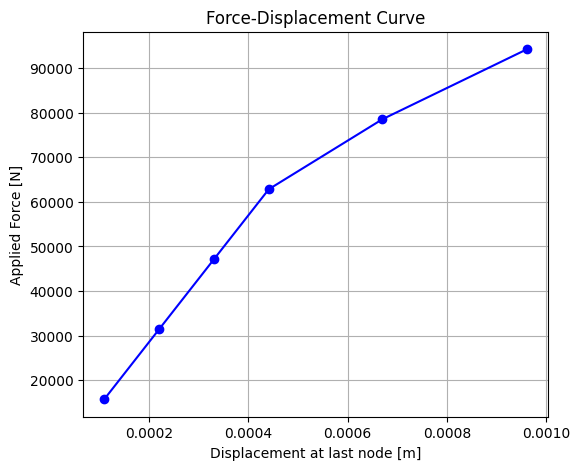

Final nodal displacements: [0.         0.00065611 0.00081484 0.00090413 0.00096127]
Element 0: strain = 2.624453e-03, stress = 3.000000e+08 Pa
Element 1: strain = 6.349206e-04, stress = 1.333333e+08 Pa
Element 2: strain = 3.571429e-04, stress = 7.500000e+07 Pa
Element 3: strain = 2.285714e-04, stress = 4.800000e+07 Pa


In [ ]:
if __name__ == "__main__":

    E = 210e9         
    sigma_y = 200e6   
    mat = Material(E, sigma_y)


    coords = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
    connectivity = np.array([[0, 1],
                             [1, 2],
                             [2, 3],
                             [3, 4]])

    A1 = np.pi * (0.02**2) / 4.0  #  0-1
    A2 = np.pi * (0.03**2) / 4.0  #  1-2
    A3 = np.pi * (0.04**2) / 4.0  #  2-3
    A4 = np.pi * (0.05**2) / 4.0  #  3-4
    areas = np.array([A1, A2, A3, A4])

    mesh = Mesh(coords, connectivity, areas, mat)

    bc = {0: 0.0}

    Fy = sigma_y * A1  
    F_ext = np.zeros(len(coords))
    F_ext[-1] = 1.5 * Fy  

    solver = FEMSolver(mesh=mesh,
                       bc=bc,
                       external_force=F_ext,
                       n_increments=6,  
                       max_iter=20,      
                       tol=1e-8)         

    U_final = solver.solve()

    print("Final nodal displacements:", U_final)
    for e_id, elem in enumerate(mesh.elements):
        print(f"Element {e_id}: strain = {elem.eps:.6e}, stress = {elem.sigma:.6e} Pa")